# 1. Install Deps

In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import tensorflow as tf
tf.__version__

'2.11.1'

In [3]:
import librosa

# 2. Data Loading

In [4]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
CAPUCHIN_FILE_2 = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC201990-5.wav')

NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [5]:
def get_melspectrogram_db(file_path, sr=48000, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80, sec=5):
    wav,sr = librosa.load(file_path,sr=sr)
    if wav.shape[0]<sec*sr:
        wav=np.pad(wav,int(np.ceil((sec*sr-wav.shape[0])/2)),mode='reflect')
    
    wav=wav[:sec*sr]
    
    spec=librosa.feature.melspectrogram(
        y=wav, sr=sr, n_fft=n_fft,
        hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax
    )
    spec_db=librosa.power_to_db(spec,top_db=top_db)
    
    return spec_db

In [6]:
wav, sr = librosa.load(CAPUCHIN_FILE_2)
# print(f"{sr} - {5*sr}")
wav.shape[0]

wav2 = np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
print(f"{wav.shape} {wav2.shape}")
print(int(np.ceil((5*sr-wav.shape[0])/2)) + wav.shape[0])

(66150,) (110250,)
88200


In [7]:
get_melspectrogram_db(CAPUCHIN_FILE, sr=48000)
get_melspectrogram_db(CAPUCHIN_FILE_2, sr=48000)

array([[ -3.4386692,  -9.925892 , -28.503838 , ..., -23.556566 ,
        -27.362625 ,  -9.141002 ],
       [ -3.146792 , -10.093039 , -27.364195 , ..., -24.984037 ,
        -21.327715 ,  -8.125993 ],
       [ -2.4396517,  -8.262404 , -33.4141   , ..., -31.504251 ,
        -26.692272 ,  -9.140289 ],
       ...,
       [-23.470839 , -29.508474 , -46.816013 , ..., -46.816013 ,
        -46.816013 , -37.22809  ],
       [-23.661196 , -29.696463 , -46.816013 , ..., -46.816013 ,
        -46.816013 , -37.40034  ],
       [-23.861088 , -29.897114 , -46.816013 , ..., -46.816013 ,
        -46.816013 , -37.66442  ]], dtype=float32)

In [8]:
wav, sr = librosa.load(NOT_CAPUCHIN_FILE)
print(f"{sr} - {5*sr}")
wav.shape[0]

wav2 = np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
print(f"{wav.shape} {wav2.shape}")

22050 - 110250
(67429,) (110251,)


In [220]:
def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    
    spec_scaled = (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.float32)
    spec_scaled = tf.expand_dims(spec_scaled, axis=2)
    return spec_scaled

In [221]:
S_1 = get_melspectrogram_db(CAPUCHIN_FILE)
S_2 = get_melspectrogram_db(NOT_CAPUCHIN_FILE)
print(f"{S_1.shape} -- {S_2.shape}")

(128, 469) -- (128, 469)


In [222]:
image_1 = spec_to_image(S_1)
image_2 = spec_to_image(S_2)

print(image_2.shape)
foo = [1, 2, 3]

(128, 469, 1)


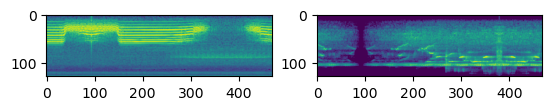

In [223]:
fig = plt.figure()
fig.add_subplot(1,2, 1)
plt.imshow(image_1)
fig.add_subplot(1,2, 2)
plt.imshow(image_2)
plt.show(block=True)

# 3. Create TF Dataset

In [224]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [225]:
pos.as_numpy_iterator().next()

b'data/Parsed_Capuchinbird_Clips/XC27881-2.wav'

In [226]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

# 4. Preprocess

In [227]:
def preprocess(filename, label=None):
    return (spec_to_image(get_melspectrogram_db(filename, sr=48000)), label)

In [228]:
spectrogram, label = preprocess(filepath, label)
print(f"{spectrogram}")
print(f"{label}")

[[[0.3907418 ]
  [0.32967633]
  [0.04408147]
  ...
  [0.02558401]
  [0.10757519]
  [0.41094172]]

 [[0.39479753]
  [0.32203487]
  [0.10870558]
  ...
  [0.02400578]
  [0.15013564]
  [0.40742615]]

 [[0.40157932]
  [0.34995806]
  [0.17694019]
  ...
  [0.1334155 ]
  [0.15898873]
  [0.4026052 ]]

 ...

 [[0.328688  ]
  [0.33303794]
  [0.3402802 ]
  ...
  [0.29653654]
  [0.31839025]
  [0.30962485]]

 [[0.3800257 ]
  [0.36981606]
  [0.35725808]
  ...
  [0.38279614]
  [0.36345974]
  [0.3254259 ]]

 [[0.31621936]
  [0.36386332]
  [0.3504887 ]
  ...
  [0.38245404]
  [0.38531837]
  [0.36909288]]]
1.0


(128, 469, 1)


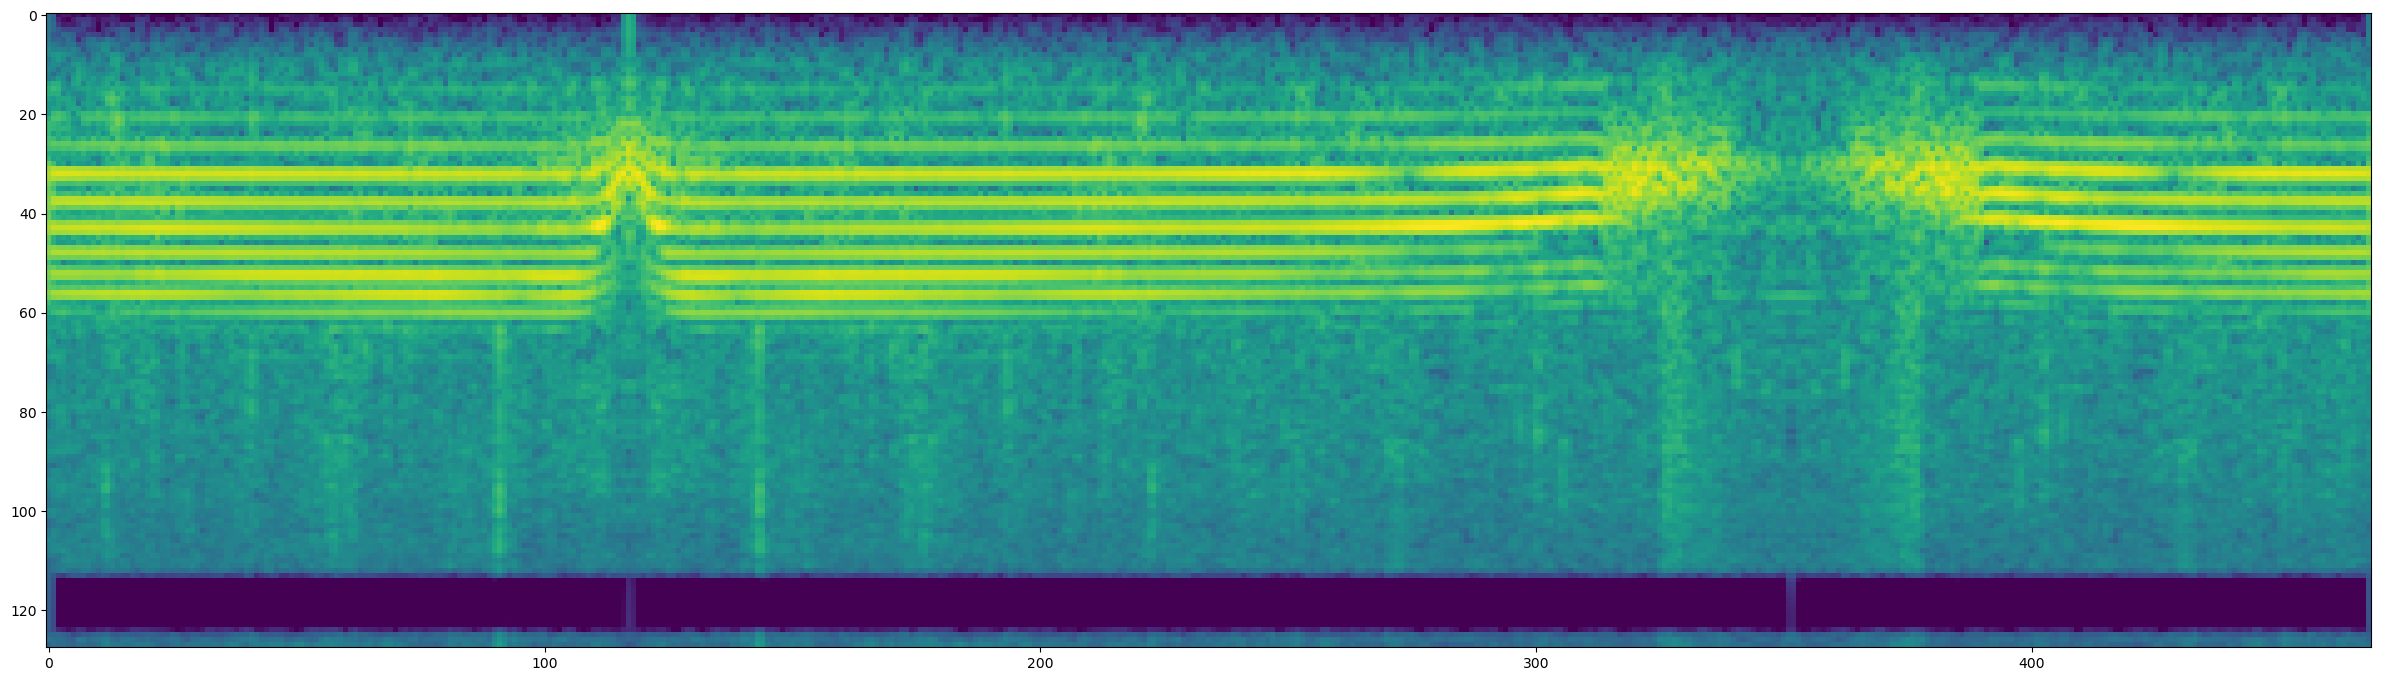

tf.float32

In [229]:
plt.figure(figsize=(30, 20))
print(spectrogram.shape)
plt.imshow(spectrogram)
# plt.imshow(tf.transpose(spectrogram))
plt.show()
spectrogram.dtype

# 5. Partition data -> train and test

In [230]:
def tf_preprocess(filename, label=None):
    np_filename = filename.numpy()
    spec = spec_to_image(get_melspectrogram_db(np_filename))

    # Normalize between 0-1
#     print(spec.shape)
#     tf_spec = tf.convert_to_tensor(spec)
    
    return spec, label

def data_map(filename, label):
    return tf.py_function(
        tf_preprocess,
        inp=[filename, label],
        Tout=[tf.float32, tf.float32]
    )

In [231]:
data = data.map(data_map)

In [232]:
data = data.cache()

In [233]:
data.as_numpy_iterator().next()

2023-05-05 12:46:53.459577: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(array([[[0.68015146],
         [0.64713025],
         [0.6506506 ],
         ...,
         [0.6472411 ],
         [0.64357764],
         [0.6848959 ]],
 
        [[0.6098039 ],
         [0.6177896 ],
         [0.64530003],
         ...,
         [0.6358991 ],
         [0.5633817 ],
         [0.5845148 ]],
 
        [[0.5224312 ],
         [0.5542838 ],
         [0.58834374],
         ...,
         [0.60624033],
         [0.5354651 ],
         [0.5476008 ]],
 
        ...,
 
        [[0.18808946],
         [0.24298203],
         [0.23628661],
         ...,
         [0.2660934 ],
         [0.23425558],
         [0.2090769 ]],
 
        [[0.20432208],
         [0.23375377],
         [0.2361416 ],
         ...,
         [0.27413875],
         [0.27502134],
         [0.277318  ]],
 
        [[0.26454788],
         [0.25625318],
         [0.19631378],
         ...,
         [0.23591122],
         [0.2604063 ],
         [0.273932  ]]], dtype=float32),
 1.0)

In [234]:
data = data.shuffle(buffer_size=10000)

In [235]:
data = data.batch(16)

In [236]:
data = data.prefetch(8)

In [237]:
train = data.take(36)
test = data.take(36)
# for el in train:
#     print(el)

In [238]:
samples, labels = train.as_numpy_iterator().next()
samples.shape
# for element in samples:
#     print(samples.shape)

2023-05-05 12:47:05.866278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 472 of 10000
2023-05-05 12:47:12.210870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


(16, 128, 469, 1)

# 6. Deep Learning Model

In [239]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [240]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(128, 469, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [242]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [243]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 126, 467, 16)      160       
                                                                 
 conv2d_11 (Conv2D)          (None, 124, 465, 16)      2320      
                                                                 
 flatten_5 (Flatten)         (None, 922560)            0         
                                                                 
 dense_10 (Dense)            (None, 128)               118087808 
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 118,090,417
Trainable params: 118,090,417
Non-trainable params: 0
_________________________________________________________________


In [244]:
hist = model.fit(train, epochs=100, validation_data=test, verbose=1)

Epoch 1/100
36/36 [==============================] - 20s 516ms/step - loss: 4.1166 - recall_5: 0.0000e+00 - precision_5: 0.0000e+00 - val_loss: 3.9634 - val_recall_5: 0.0000e+00 - val_precision_5: 0.0000e+00
Epoch 2/100
36/36 [==============================] - 20s 548ms/step - loss: 4.0973 - recall_5: 0.0000e+00 - precision_5: 0.0000e+00 - val_loss: 4.0973 - val_recall_5: 0.0000e+00 - val_precision_5: 0.0000e+00
Epoch 3/100
36/36 [==============================] - 20s 555ms/step - loss: 3.8027 - recall_5: 0.0000e+00 - precision_5: 0.0000e+00 - val_loss: 4.2044 - val_recall_5: 0.0000e+00 - val_precision_5: 0.0000e+00
Epoch 4/100
36/36 [==============================] - 18s 501ms/step - loss: 3.9366 - recall_5: 0.0000e+00 - precision_5: 0.0000e+00 - val_loss: 3.8830 - val_recall_5: 0.0000e+00 - val_precision_5: 0.0000e+00
Epoch 5/100
36/36 [==============================] - 18s 498ms/step - loss: 4.1776 - recall_5: 0.0000e+00 - precision_5: 0.0000e+00 - val_loss: 4.0973 - val_recall_5: 0

36/36 [==============================] - 15s 423ms/step - loss: 4.2847 - recall_5: 0.0000e+00 - precision_5: 0.0000e+00 - val_loss: 4.1508 - val_recall_5: 0.0000e+00 - val_precision_5: 0.0000e+00
Epoch 80/100
36/36 [==============================] - 13s 360ms/step - loss: 4.2311 - recall_5: 0.0000e+00 - precision_5: 0.0000e+00 - val_loss: 4.3918 - val_recall_5: 0.0000e+00 - val_precision_5: 0.0000e+00
Epoch 81/100
36/36 [==============================] - 13s 370ms/step - loss: 3.8830 - recall_5: 0.0000e+00 - precision_5: 0.0000e+00 - val_loss: 3.9634 - val_recall_5: 0.0000e+00 - val_precision_5: 0.0000e+00
Epoch 82/100
36/36 [==============================] - 13s 359ms/step - loss: 4.0169 - recall_5: 0.0000e+00 - precision_5: 0.0000e+00 - val_loss: 4.1776 - val_recall_5: 0.0000e+00 - val_precision_5: 0.0000e+00
Epoch 83/100
36/36 [==============================] - 16s 433ms/step - loss: 3.9098 - recall_5: 0.0000e+00 - precision_5: 0.0000e+00 - val_loss: 4.1508 - val_recall_5: 0.0000e+0

In [245]:
hist.history

{'loss': [4.116567134857178,
  4.097252368927002,
  3.802678108215332,
  3.9365756511688232,
  4.177590370178223,
  4.097252368927002,
  4.097251892089844,
  4.177590847015381,
  4.445384979248047,
  4.177590847015381,
  4.231149673461914,
  4.1775898933410645,
  4.204370498657227,
  3.99013352394104,
  4.231148719787598,
  4.3918256759643555,
  4.1240315437316895,
  4.204370021820068,
  4.1240315437316895,
  4.124032020568848,
  4.0436930656433105,
  4.150811195373535,
  4.338266372680664,
  4.257928848266602,
  4.204370498657227,
  4.365046977996826,
  3.9901347160339355,
  4.231148719787598,
  3.749119281768799,
  4.0704731941223145,
  4.016914367675781,
  4.150811672210693,
  4.016912937164307,
  4.365046501159668,
  4.124032497406006,
  4.0972514152526855,
  4.0436930656433105,
  4.2311482429504395,
  4.231149673461914,
  4.20436954498291,
  4.284708023071289,
  4.150811672210693,
  4.0436930656433105,
  3.9901342391967773,
  4.418605327606201,
  4.177590370178223,
  4.01691389083

# 7. Plot Model

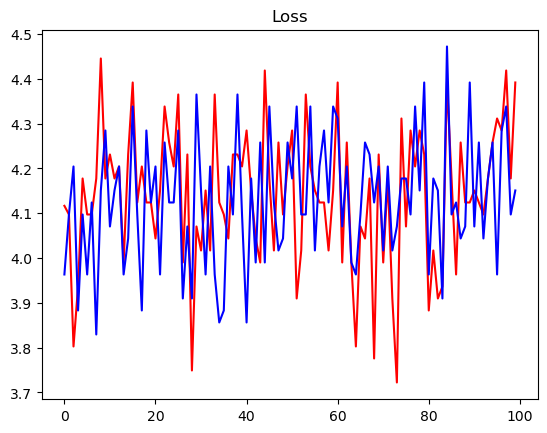

In [246]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

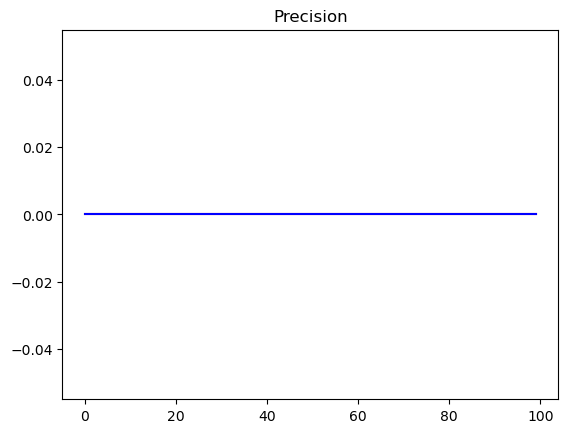

In [248]:
plt.title('Precision')
plt.plot(hist.history['precision_5'], 'r')
plt.plot(hist.history['val_precision_5'], 'b')
plt.show()

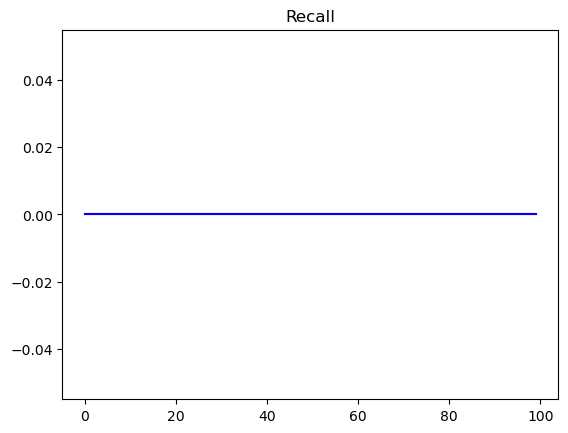

In [249]:
plt.title('Recall')
plt.plot(hist.history['recall_5'], 'r')
plt.plot(hist.history['val_recall_5'], 'b')
plt.show()